In [15]:
# basics

import numpy as np
import pandas as pd


# matplotlib

import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve
import os
CWD = "/".join(os.getcwd().split("/")[:-2])


import astropy.units as u
from astropy.constants import R_sun

# Plot stuff
from funcs.model import full_model, aflare_decoupled

# get flare properties

In [16]:
res= pd.read_csv(f"{CWD}/analysis/results/mcmc/15_12_2020_GP_mcmcoutput.csv")
res.suffix = res.suffix.fillna("").astype(str)
vals = list(res.columns.values)
vals.remove("suffix")
vals.remove("tstamp")
vals.remove("color")
vals.remove("linestyle")
vals.remove("ID")
res[vals] = res[vals].astype(float) 

In [20]:
# calculate individual fl
est = {}

# Pick up the input parameters
inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")

# Pick up stellar properties
props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

for j, row in res.iterrows():
  
    # Get data for the flare
    lc = pd.read_csv(f"{CWD}/data/lcs/{row.tstamp}_{row.ID}.csv")
    target = props[props.ID == int(row.ID)].iloc[0]
    inits_ = inits[(inits.ID == str(row.ID)+row.suffix) & (inits.tstamp==row.tstamp)].iloc[0]

    
    # get flare and star parameters for model
    
    qlum = inits_.qlum_erg_s * u.erg / u.s
    Fth = inits_.Fth * u.erg/ u.cm**2 / u.s
    median = inits_['median']
    R = inits_.R_Rsun * R_sun

    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values


    a = row.a_50
    phi_a = (row.t0_d_50 -lc.t[0]) / target.Prot_d * 2 * np.pi 
    fwhm1 = row.fwhm1_d_50 / target.Prot_d * 2 * np.pi
    fwhm2 = row.fwhm2_d_50 / target.Prot_d * 2 * np.pi
  
    i = np.pi/2 # put yourself in the orbital plane of a spin-orbit aligned star

    # calculate flare longitude from peak flare time
    phi0 = phi_a%(2.*np.pi) - (row.phase_deg_50  / 180 * np.pi)
 
    print(f"ID: {row.ID}\n")
    
    # add an entry for each flare
    est[str(row.ID) + row.suffix] = {}
    
    # put flares at different latitudes
    for theta_a in np.arange(0.1,89.9,2): 
        th = theta_a / 180. * np.pi
        fullmodel = full_model(phi_a, th, a, fwhm1, fwhm2, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        
        est[str(row.ID) + row.suffix][theta_a] = ED * qlum.value

            

ID: 452922110

ID: 277539431

ID: 237880881

ID: 237880881

ID: 44984200

ID: 44984200



In [21]:
# convert dict to DataFrame
esti = pd.DataFrame(est)

# normalize by equatorial flux
esti2 = esti/esti.loc[.1]

237880881a
44984200a


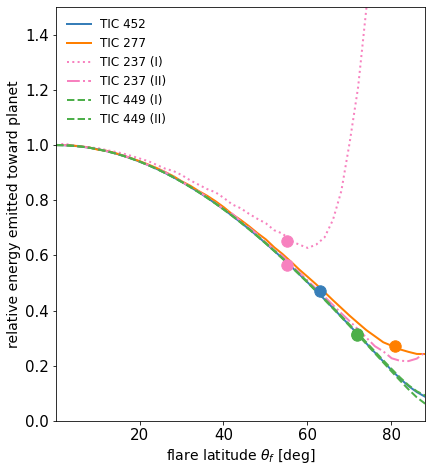

In [12]:
plt.figure(figsize=(6,6.5))
res.ID = res.ID.astype(str)

for col in esti2:
    
    # disambiguate 2-flare solutions
    if "a" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "a")]
        suff = " (I)"
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " (II)"
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
        
    # pick consistent color and linestyle
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    
    # compile label using disambiguation above
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    
    # plot latitude dependence
    plt.plot(esti2.index, esti2[col], color=c, label=lab, linestyle=l, linewidth=2, zorder=-4)
    
    # plot individual flares
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str(col)]
    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=130, alpha=1.)
    

# layout

plt.legend(frameon=False, fontsize=12)
plt.xlim(0.1,88.)
plt.ylim(0,1.5)
plt.ylabel(r"relative energy emitted toward planet", fontsize=14)
plt.xlabel(r"flare latitude $\theta_f$ [deg]", fontsize=14)
plt.tight_layout();

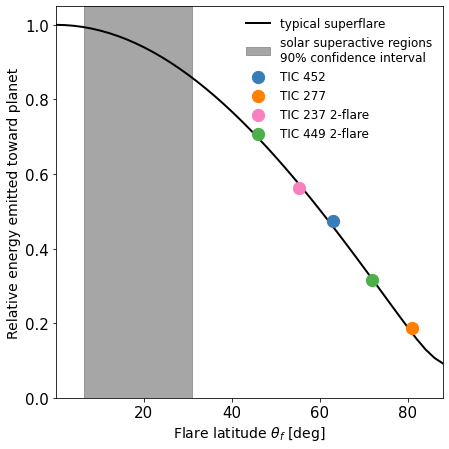

In [23]:
plt.figure(figsize=(6.5,6.5))
res.ID = res.ID.astype(str)
#esti2 = esti2.drop("100004076", axis=1)
for col in esti2:
    
    # disambiguate 2-flare solutions
    if "a" in col:
        continue
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " 2-flare"
        
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    
           
    # pick consistent color and linestyle
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    
    # compile label using disambiguation above
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    
    # 
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str("44984200a")]

    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=150, alpha=1.,label=lab)

# typical superflare energy modulation
plt.plot(esti2.index, esti2["44984200a"], color ="k", 
         label="typical superflare", linestyle="solid", 
         linewidth=2, zorder=-4)

# solar superactive regions
plt.axvspan(6.4, 31., color="grey", zorder=-20, alpha=0.7, 
            label="solar superactive regions\n90% confidence interval")

# layout

plt.legend(frameon=False, fontsize=12, loc=1)
plt.xlim(0.1,88.)
plt.ylim(0.,1.05)
plt.tight_layout()
plt.ylabel(r"Relative energy emitted toward planet", fontsize=14)
plt.xlabel(r"Flare latitude $\theta_f$ [deg]", fontsize=14)
plt.tight_layout()

# plt.savefig(f"/home/ekaterina/Documents/002_writing/multiperiod-flares-draft/"
#             f"nature/multiperiodflaresnature/figures/15_12_2020_solar_comparison.png",
#            dpi=300);